In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


# Read in the Data and begin EDA 

In [27]:
import matplotlib.pyplot as plt 

import seaborn as sns 

In [28]:
train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')

test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

In [29]:
train.head()

test.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


# do train features match test features ? 

In [30]:
print("Mismatch Features between Train and Test: {}".format(set(train.columns).difference(test.columns)))

Mismatch Features between Train and Test: {'Hardness'}


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


# Visualizing Feature distributions and correlation!

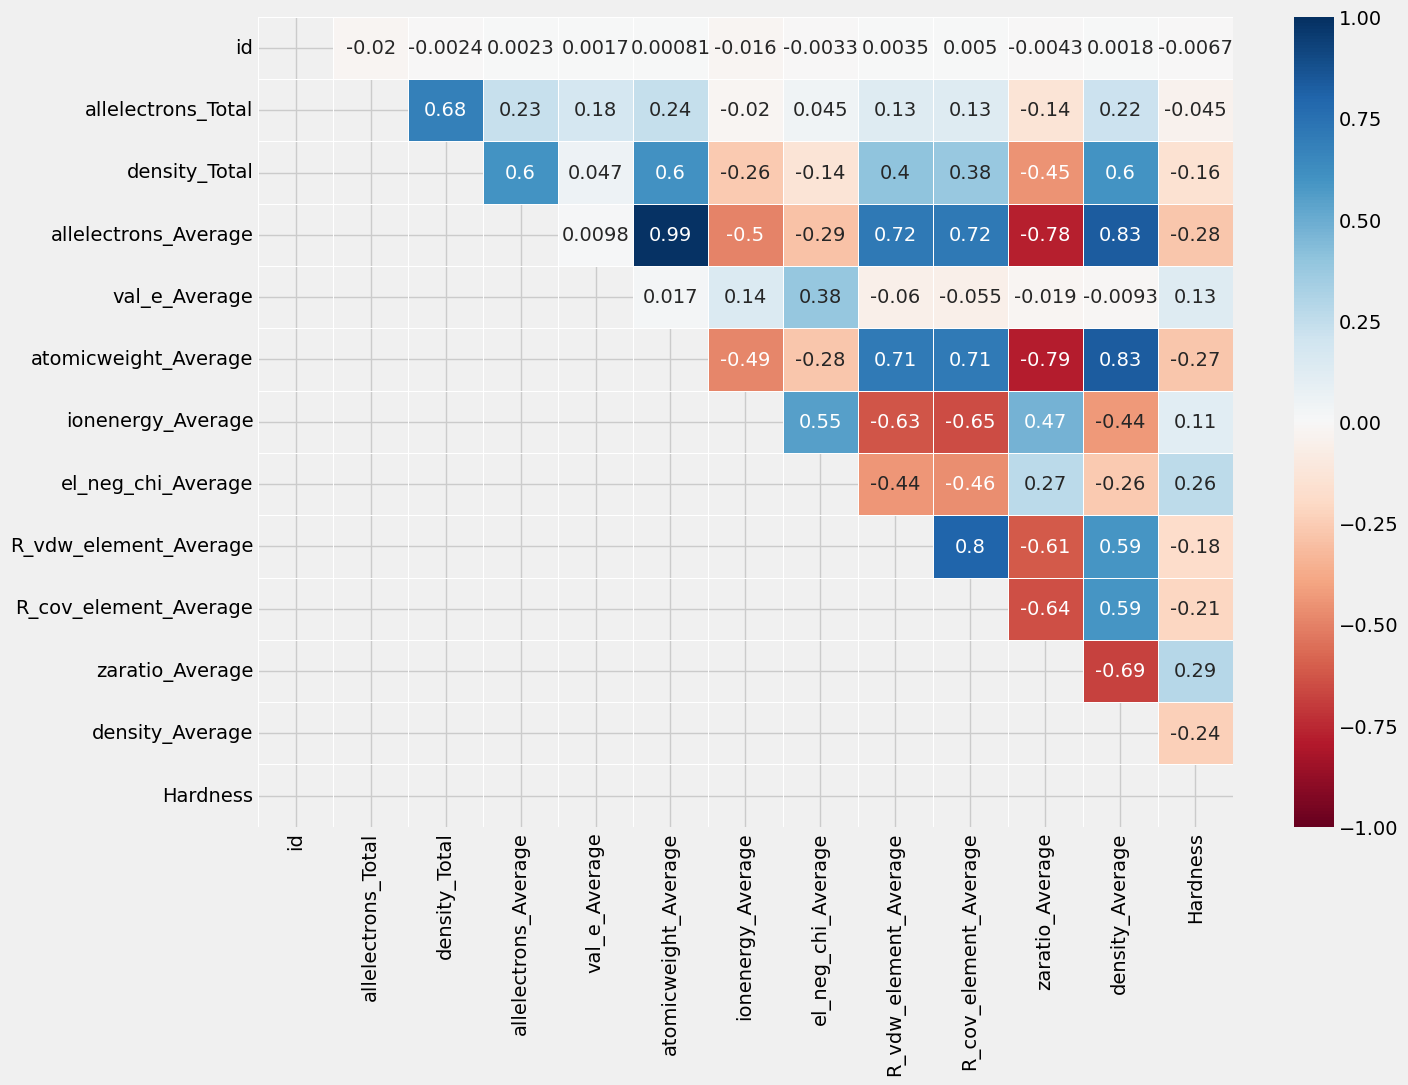

In [32]:
corr = train.corr(method='spearman')

plt.figure(figsize=(14, 10))

mask = np.ones_like(corr)

mask[np.triu_indices_from(mask, k=1)] = 0

sns.heatmap(corr, linewidth=0.5, annot=True, cmap="RdBu", vmin=-1, vmax=1,mask=mask)


plt.show()

In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def drop_correlated_features(df, target_column=None, threshold=0.8):
    """
    Drop correlated features from a DataFrame based on a correlation threshold and lowest feature importance.

    Parameters:
    - df: pandas DataFrame
        The input DataFrame with features.
    - target_column: str
        The name of the target column for training the machine learning model.
    - threshold: float, optional (default=0.8)
        The correlation threshold. Features with correlation coefficients above this threshold will be considered correlated.

    Returns:
    - pandas DataFrame
        A new DataFrame with correlated features removed based on lowest feature importance.
    """
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # List to store features to be dropped
    features_to_drop = []

    # Identify and drop correlated features based on lowest feature importance
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > abs(threshold):
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                if target_column is not None:
                    # Train a Random Forest model to get feature importances
                    X = df[[feature1, feature2]]
                    y = df[target_column]

                    model = RandomForestRegressor()  # or RandomForestRegressor for regression tasks
                    model.fit(X, y)

                    # Get feature importances
                    importances = model.feature_importances_

                    # Choose the feature with the lowest importance to drop
                    if importances[0] < importances[1]:
                        features_to_drop.append(feature1)
                    else:
                        features_to_drop.append(feature2)

    # Drop the identified features
    df = df.drop(columns=features_to_drop)
    
    print("Features Dropped:",features_to_drop)

    return df

# Example usage:
# Assuming df is your DataFrame, and 'target' is the target column for your model
# The function will drop correlated features with a default threshold of 0.8
# based on the lowest feature importance in each correlated pair


# dropping a features that are colinear, we drop the feature with the lower feature importance 

In [34]:
train_new = drop_correlated_features(train,'Hardness',threshold=.9)

train_new

Features Dropped: ['atomicweight_Average']


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.000000,4.800000,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.000000,4.800000,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.600000,5.600000,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.000000,4.800000,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.600000,4.800000,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,10402,128.0,7.558488,12.000000,4.000000,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,10403,30.0,1.743160,10.000000,5.333333,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,10404,196.0,30.920000,24.500000,5.500000,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,10405,38.0,1.553160,12.666667,4.666667,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


In [35]:
##this resulted in worse results

##def find_outliers_IQR(df):

   ## q1=df.quantile(0.25)

    ##q3=df.quantile(0.75)

   ## IQR=q3-q1

   ## outliers = ((df<(q1- 1.5 *IQR)) | (df>(q3+ 1.5 *IQR)))
##
   ## return outliers

In [36]:
##after using IQR method, we get worse model performance! 

##outliers = find_outliers_IQR(train_new)

##train_new = train_new[~outliers]

##train_new = train_new.fillna(train_new.median())

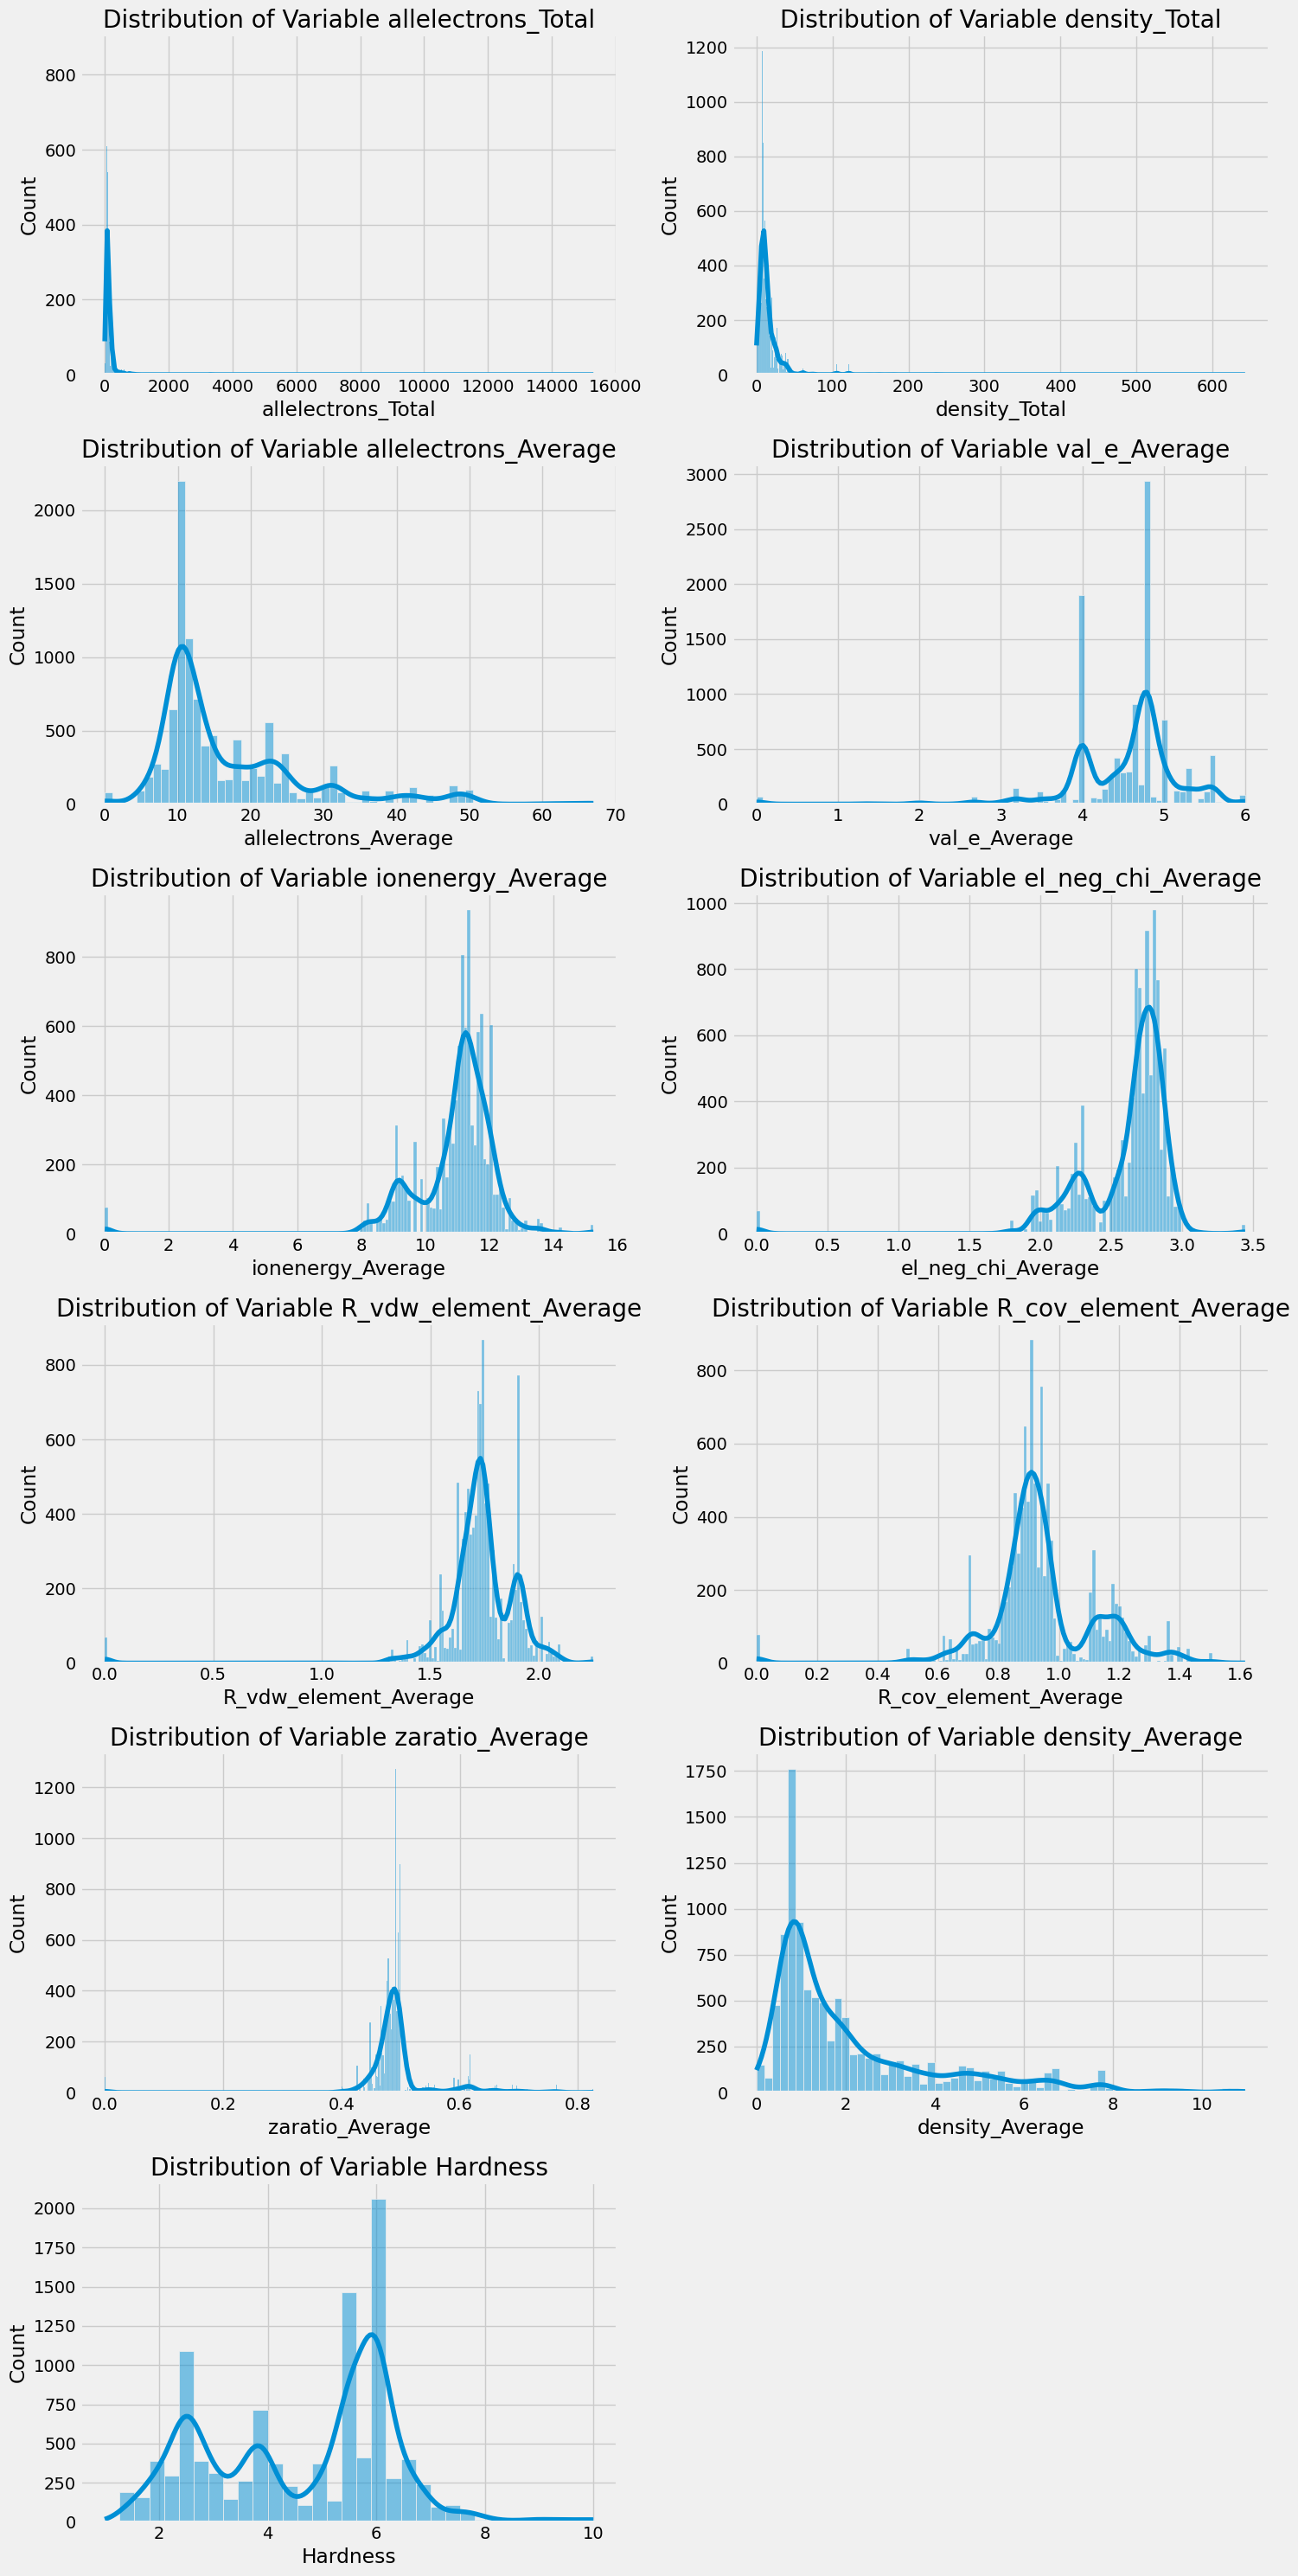

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

# Get the list of float columns in your DataFrame
float_columns = train_new.select_dtypes('float').columns

# Calculate the number of rows and columns in the subplot grid
num_cols = 2  # You can adjust this based on how many columns you want side by side
num_rows = (len(float_columns) + num_cols - 1) // num_cols

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array if it's more than 1D
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, col in enumerate(float_columns):
    if col == 'id': 
        continue 
    ax = axes[i]
    sns.histplot(train[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of Variable {col}')

# Remove empty subplots if the number of features is not a multiple of num_cols * num_rows
for i in range(len(float_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Defining a function to eliminate outliers using the RobustScaler

In [38]:
train_new.columns

Index(['id', 'allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'ionenergy_Average', 'el_neg_chi_Average',
       'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average',
       'density_Average', 'Hardness'],
      dtype='object')

# Applying Relevant transformations to skewed feature distributions.

In [39]:
right_tailed = ['density_Average','allelectrons_Total','density_Total','density_Average']

left_tailed = ['el_neg_chi_Average','R_vdw_element_Average','ionenergy_Average','val_e_Average']

In [40]:
from scipy.stats import boxcox, yeojohnson

from scipy.special import boxcox1p

for feat in right_tailed: 
    
    train_new[feat] = np.log1p(train_new[feat])
    
    test[feat] = np.log1p(test[feat])
    
for feat in left_tailed: 
    
    train_new[feat] = np.sqrt(train_new[feat])
    
    test[feat] = np.sqrt(test[feat])

# Trying to transform all using boxcox, (lets visualize these again)!

In [41]:
##for feat in train.columns:
    
   ## if feat == 'Hardness':
   ##     continue
    
  ##  train[feat],lambda_ = boxcox(train[feat])
    
  ##  test[feat] = boxcox(test[feat],lambda_)
    

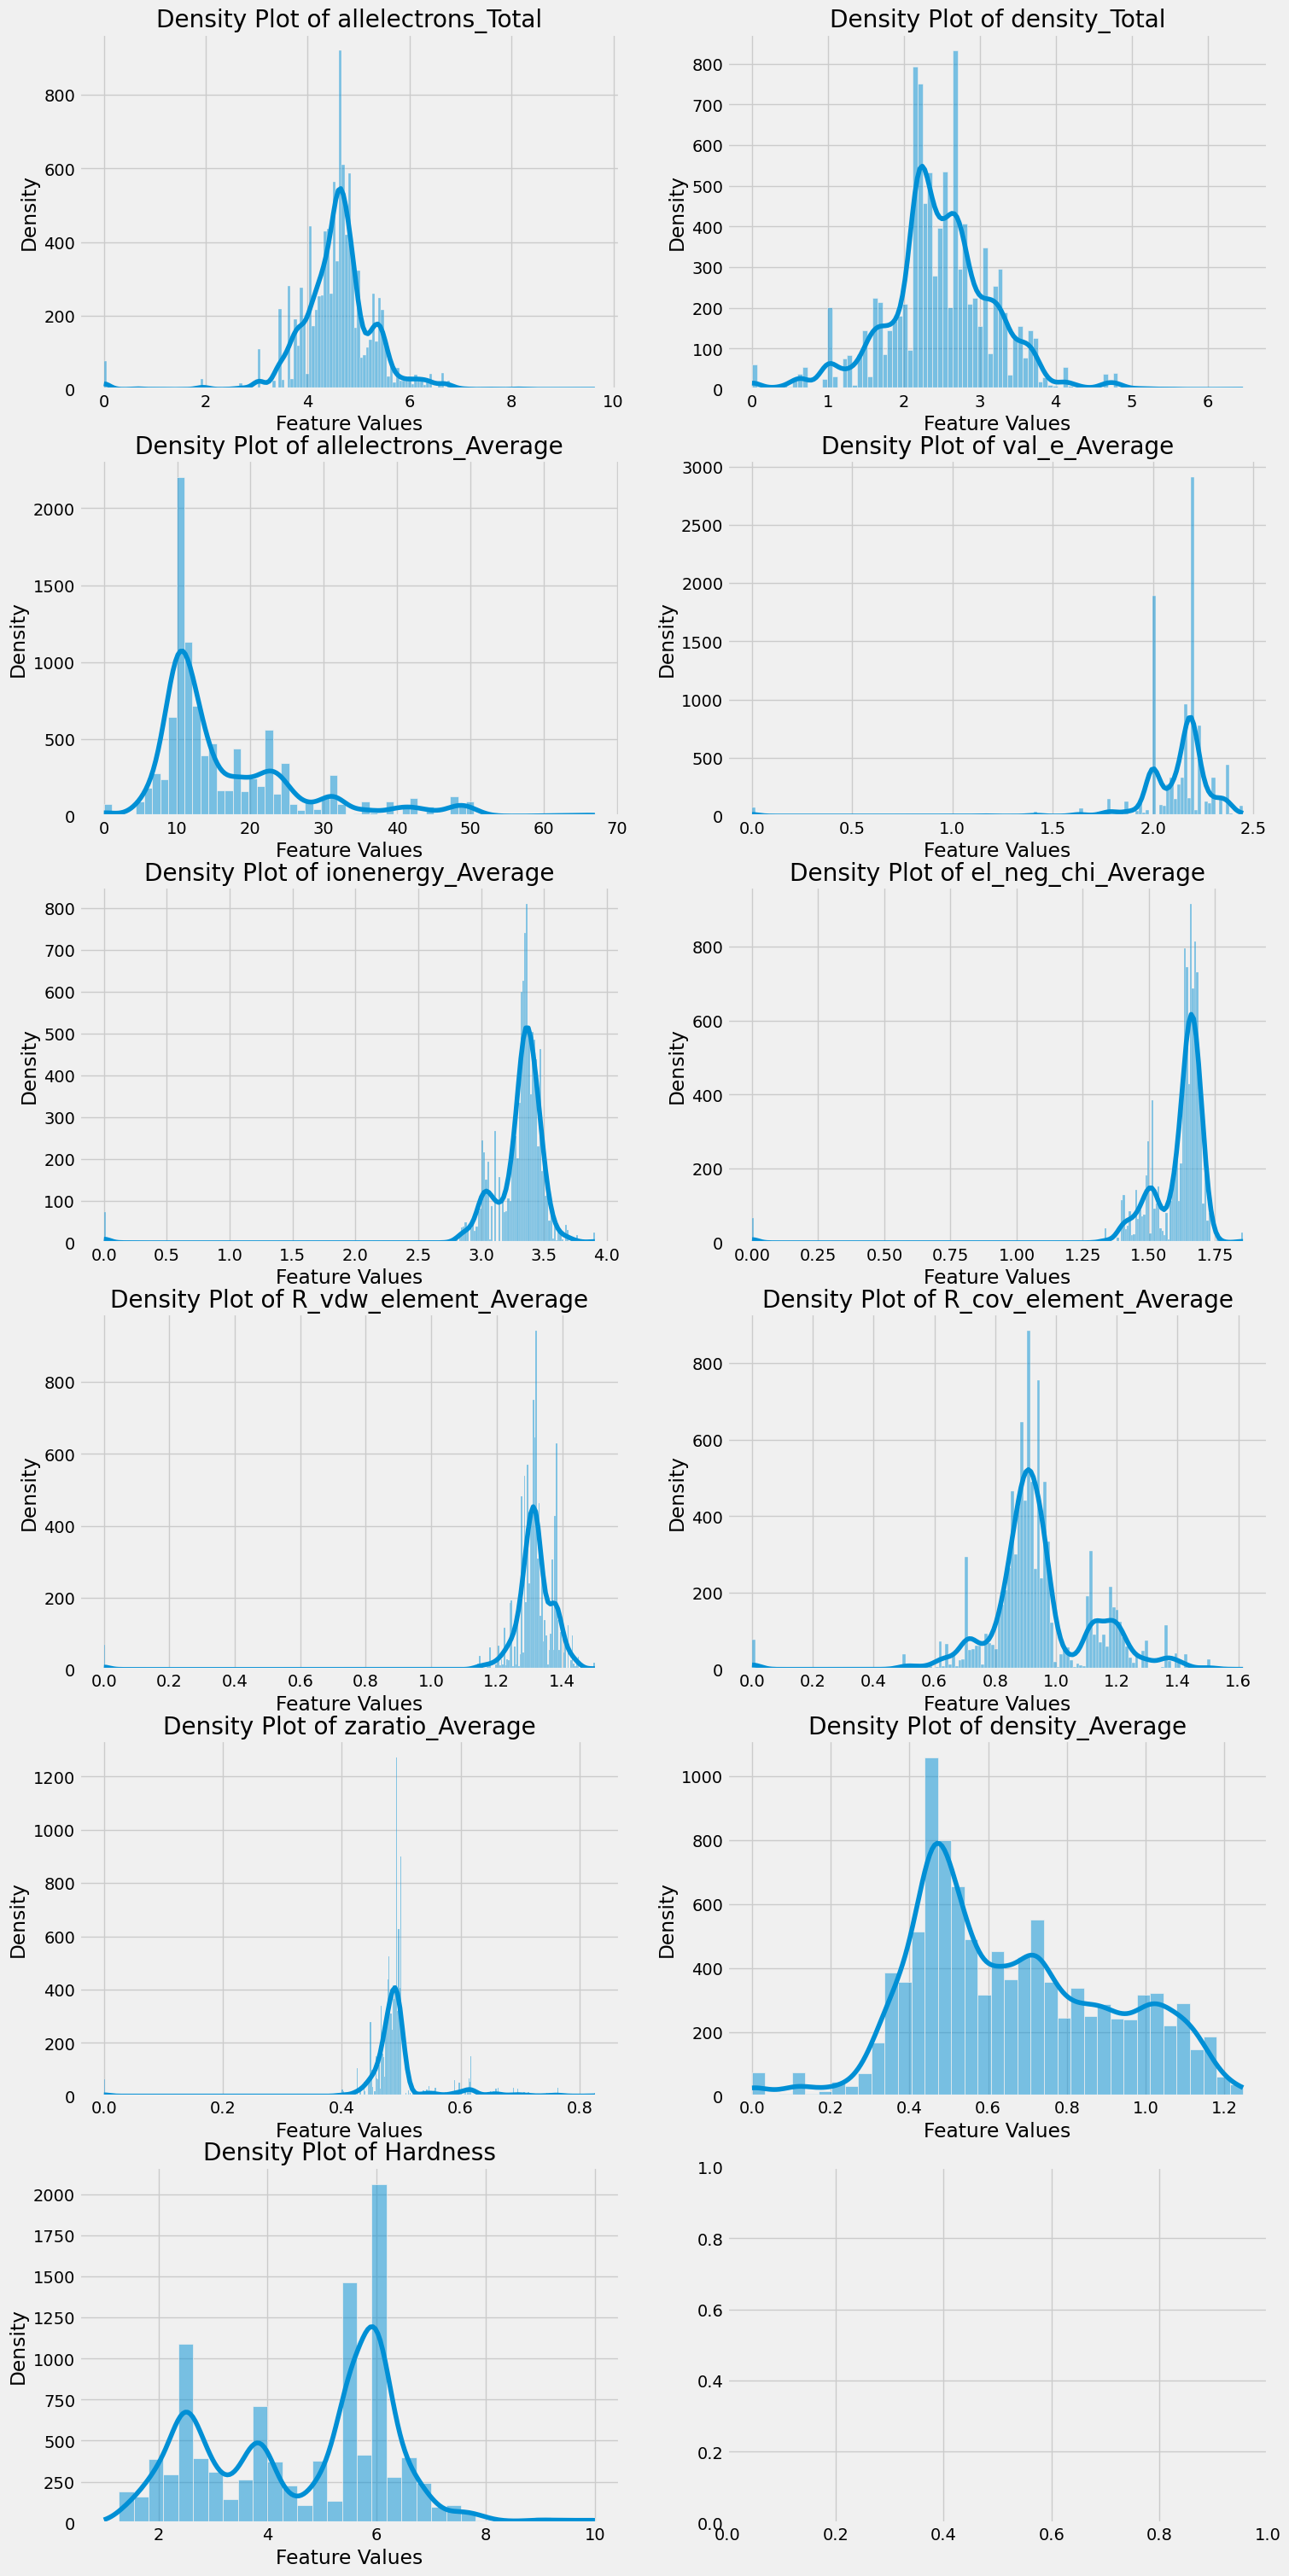

In [42]:
numeric_cols = train_new.select_dtypes('float').columns

num_cols = 2 

num_plots = len(numeric_cols)

num_rows = (num_plots + 1) // 2 

_, axes = plt.subplots(nrows= num_rows, ncols=num_cols,figsize=(8*num_cols,6*num_rows))

for i, feature_name in enumerate(numeric_cols):
    
    if feature_name == 'id':
        continue
    
    row_idx,col_idx = divmod(i,num_cols)

    sns.histplot(data = train_new,x=feature_name,kde=True, ax=axes[row_idx,col_idx])

    axes[row_idx,col_idx].set_title(f'Density Plot of {feature_name}')

    axes[row_idx,col_idx].set_xlabel('Feature Values')

    axes[row_idx,col_idx].set_ylabel('Density')

# Process Testing to Match Training Features

In [43]:
features_to_drop = set(test.columns).difference(train_new.columns)

test_new = test.drop(columns = list(features_to_drop),axis=1)

# Inspecting Missing Values and removing them from our training set

In [44]:
pd.set_option('display.max_rows',250)

train_subset = train_new[train_new.select_dtypes('float').values == 0]

values_to_drop = list(train_subset.id.unique())

print('Number of Rows with Missing Values: {}'.format(len(values_to_drop)))

Number of Rows with Missing Values: 120


In [45]:
train_new = train_new[~train_new['id'].isin(values_to_drop)]

print('Rows of Data Dropped: {}'.format(abs(train_new.shape[0] - train.shape[0])))

Rows of Data Dropped: 120


In [46]:
train_new.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000,10287.000000
mean,5196.629824,4.606608,2.494356,17.190811,2.135513,3.315219,1.618317,1.319304,0.951419,0.496095,0.663837,4.662870
std,3004.402700,0.662422,0.686054,10.407763,0.141653,0.161193,0.082600,0.049897,0.160263,0.050047,0.244517,1.670717
min,0.000000,0.639219,0.125639,4.040404,1.154701,2.673218,1.273917,1.013903,0.120000,0.401635,0.010675,1.000000
25%,2589.500000,4.234107,2.146924,10.000000,2.000000,3.255750,1.590597,1.293252,0.865000,0.476196,0.469558,3.000000
50%,5196.000000,4.615121,2.468438,12.600000,2.179449,3.349293,1.644992,1.316878,0.918333,0.488550,0.622174,5.500000
75%,7798.500000,4.882802,2.872264,22.000000,2.190890,3.416726,1.674813,1.345943,0.982500,0.496070,0.845775,6.000000
max,10406.000000,9.635673,6.467844,67.000000,2.449490,3.904588,1.855532,1.500000,1.615840,0.825990,1.247723,10.000000


# Imports

In [47]:
from sklearn.pipeline import Pipeline 

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR 

import xgboost as xgb 

import lightgbm as lgb 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [48]:
X, y = train_new.iloc[:,1:-1],train_new.iloc[:,-1]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,shuffle=True, random_state=1)

# Instantiating models and assessing out of box performance!

In [50]:
models = {'Ridge':Ridge(),
          'SVR':SVR(),
         'XGBoost':xgb.XGBRegressor(),
         'LightGBM':lgb.LGBMRegressor(),
         'Random Forest':RandomForestRegressor()}

In [51]:
pipelines = {}

from sklearn.metrics import median_absolute_error

for model_name, model in models.items(): 
    
    pipeline = Pipeline([('Scaler',StandardScaler()),
              (f'{model_name}',model)])
    
    pipelines[model_name] = pipeline
    
    pipeline.fit(X_train,y_train) 
    
    train_preds = pipeline.predict(X_train)
    
    test_preds = pipeline.predict(X_test)
    
    train_rmse = median_absolute_error(y_train, train_preds)
    
    test_rmse = median_absolute_error(y_test,test_preds)
    
    train_r2 = round(r2_score(y_train, train_preds),2)
    
    test_r2 = round(r2_score(y_test,test_preds),2)
    
    print(f'Train Median Abs Error, R2 of {model_name} is {round(train_rmse,2)}, {train_r2}',)
        
    print(f'Test Median Abs Error, R2 of {model_name} is :{round(test_rmse,2)}, {test_r2}')

Train Median Abs Error, R2 of Ridge is 0.94, 0.26
Test Median Abs Error, R2 of Ridge is :0.94, 0.28
Train Median Abs Error, R2 of SVR is 0.56, 0.42
Test Median Abs Error, R2 of SVR is :0.6, 0.39
Train Median Abs Error, R2 of XGBoost is 0.33, 0.84
Test Median Abs Error, R2 of XGBoost is :0.67, 0.45
Train Median Abs Error, R2 of LightGBM is 0.53, 0.65
Test Median Abs Error, R2 of LightGBM is :0.63, 0.49
Train Median Abs Error, R2 of Random Forest is 0.24, 0.92
Test Median Abs Error, R2 of Random Forest is :0.64, 0.46


In [52]:
scaler = RobustScaler() 

X_train['allelectrons_Total'] = scaler.fit_transform(X_train[['allelectrons_Total']])

X_test['allelectrons_Total'] = scaler.transform(X_test[['allelectrons_Total']])

test_new['allelectrons_Total'] = scaler.transform(test_new[['allelectrons_Total']])

# Based on our results we will look to build RF, XGB (of course)

In [53]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Assume you have your data in X_train and y_train
# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define parameters for XGBoost
params = {'objective': 'reg:absoluteerror',  # for regression tasks
    'eval_metric': 'mae',  # Use MAE as the evaluation metric
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'colsample_bytree': .6,
    'lambda':.8,
    'gamma':.1
}

# Perform cross-validation using xgb.cv
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,  # Maximum number of boosting rounds
    early_stopping_rounds=200,  # Stop if performance doesn't improve for 10 rounds
    nfold=10,  # Number of folds in cross-validation
    metrics='mae',  # Use MAE as the evaluation metric
    seed=42,
    stratified=False,  # For regression tasks, set to False
    custom_metric=lambda preds, dtrain: ('mae', np.median(np.abs(preds - dtrain.get_label())))
)

# Access the median absolute error for each fold and round
mae_results = cv_results['test-mae-mean']

# Find the round with the lowest median absolute error
best_round = np.argmin(mae_results)
best_mae = mae_results[best_round]

print(f"Best Round: {best_round + 1}")
print(f"Best Median Absolute Error: {best_mae}")

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_round+1)

Best Round: 178
Best Median Absolute Error: 0.5511021


Train a new XGB based on results of XGBCV! 

In [54]:
params = {'objective': 'reg:absoluteerror',  # for regression tasks
    'eval_metric': 'mae',  # Use MAE as the evaluation metric
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'colsample_bytree': .6,
    'lambda':.8,
    'gamma':.1
}

xgb_ = xgb.XGBRegressor(**params,n_estimators=180)

In [55]:
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import KFold, cross_val_score,RandomizedSearchCV

kf = KFold(n_splits=5, shuffle=True, random_state=12)

rf = RandomForestRegressor(n_estimators = 100,
                          criterion = 'absolute_error',
                           bootstrap=True)

params = {'max_features':['log2','sqrt'],
         'max_depth':[4,6,8,10]}

rf_cv = RandomizedSearchCV(rf,params, n_iter =10, cv=kf, n_jobs=-1,
                           scoring='neg_median_absolute_error')

rf_cv.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
                   estimator=RandomForestRegressor(criterion='absolute_error'),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8, 10],
                                        'max_features': ['log2', 'sqrt']},
                   scoring='neg_median_absolute_error')

In [56]:
rf_cv.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='sqrt')

In [57]:
print(f'Random Forest 5-Fold CV Score: {abs(rf_cv.best_score_)}')

Random Forest 5-Fold CV Score: 0.5736499999999992


In [58]:
lgbm = lgb.LGBMRegressor( boosting_type = 'gbdt',
                         objective = 'mae',
                         min_samples_leaf=40,
   ##num_leaves = 40,
   max_depth = 50,
    learning_rate = 0.1,
   n_estimators = 500,
    ##subsample_freq: int = 0,
    colsample_bytree =  .9,
   ## reg_alpha = 0.0,
    ##reg_lambda = 0.01,
    random_state = 42,
    n_jobs = -1)

lgbm_score = abs(cross_val_score(lgbm, X_train,y_train, cv= kf, scoring = 'neg_median_absolute_error').mean())

lgbm_score

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.530740239602019

In [59]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(loss='absolute_error',early_stopping=True)

hgbr_score = abs(cross_val_score(hgbr,X_train,y_train,scoring='neg_median_absolute_error',cv=5).mean())

In [60]:
from sklearn.model_selection import RandomizedSearchCV 

params = {'learning_rate':[.05,.1],
          'max_iter':[200,300,400],
         'min_samples_leaf':[20,30,40,50],
         'l2_regularization':[0,.1,.5]}

hgbr_cv = RandomizedSearchCV(hgbr, params,n_iter=10,
                             scoring='neg_median_absolute_error',
                             n_jobs=1,
                             random_state=42,cv=5)

hgbr_cv.fit(X_train,y_train)

hgbr_cv.best_score_, hgbr_cv.best_estimator_

(-0.5322436293745161,
 HistGradientBoostingRegressor(early_stopping=True, l2_regularization=0.1,
                               learning_rate=0.05, loss='absolute_error',
                               max_iter=400, min_samples_leaf=40))

In [61]:
from sklearn.ensemble import VotingRegressor

gb_voter = VotingRegressor(estimators=[('HistGB',hgbr_cv.best_estimator_),('LightGBM',lgbm),('XGBoost',xgb_),('RandomForest',rf)],
                           n_jobs=-1,weights=[5,4,.5,.2])

gb_voter.fit(X_train,y_train)

gbv_preds = gb_voter.predict(X_test)

median_absolute_error(y_test,gbv_preds)

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


0.5053110061701642

# Plotting Errors

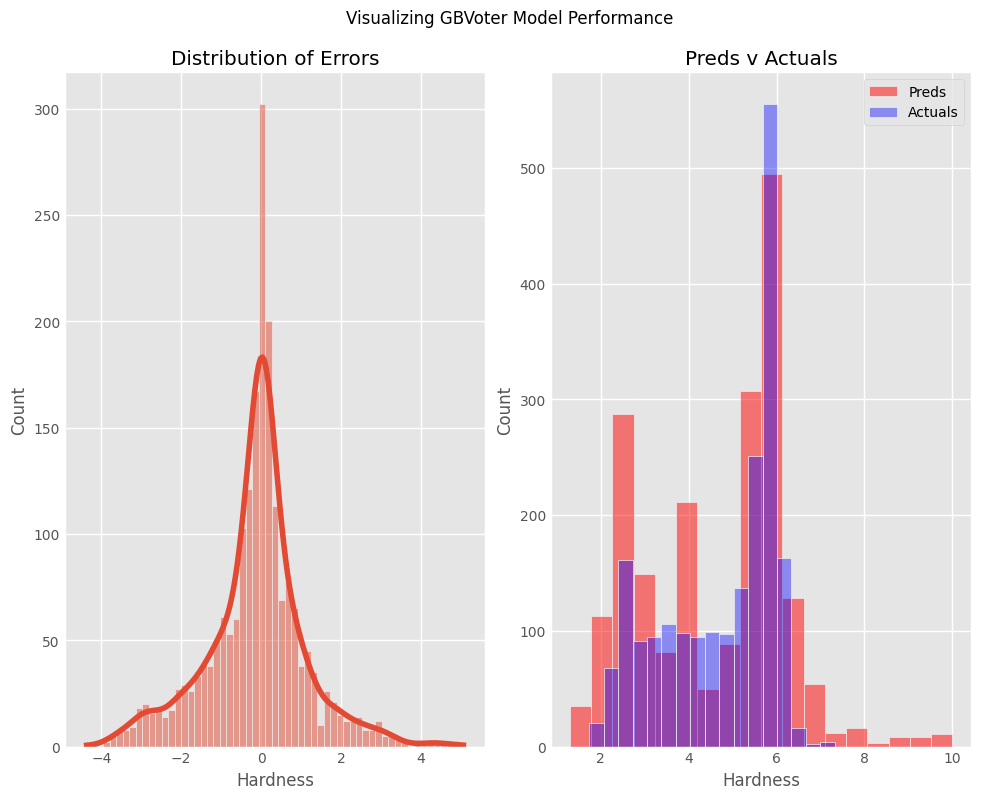

In [62]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,8))

fig.suptitle('Visualizing GBVoter Model Performance')

plt.tight_layout(pad=2)

sns.histplot(y_test-gbv_preds,kde=True,ax=ax1) 

ax2 = sns.histplot(y_test,alpha=.5,color='red')

sns.histplot(gbv_preds,alpha=.4,ax=ax2,color='blue')

ax1.set_title('Distribution of Errors')

ax2.set_title('Preds v Actuals')

ax2.legend(['Preds','Actuals'])

plt.show()

In [63]:
test1 = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

test1['id']

0       10407
1       10408
2       10409
3       10410
4       10411
        ...  
6934    17341
6935    17342
6936    17343
6937    17344
6938    17345
Name: id, Length: 6939, dtype: int64

In [64]:
test_new.drop('id',axis=1,inplace=True)

final_pred = gb_voter.predict(test_new)

submission = pd.DataFrame({'id':test['id'],'Hardness':final_pred})

In [65]:
submission.to_csv('vote_rf_outliers_included.csv',index=False)